# Telecom X — Análisis de Evasión (Churn) de Clientes

**Objetivo:** extraer, limpiar y transformar datos de clientes desde un JSON; realizar un **EDA** para entender patrones de **churn** y entregar un **informe final** con hipótesis/acciones para el equipo de ciencia de datos.  
**Alcance del challenge:** enfoque en **ETL y EDA** (no modelado predictivo).  


#**Importaciones**

In [4]:
# ===== Setup e importaciones =====
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
JSON_PATH = Path("/content/TelecomX_Data.json")


#📌 Extracción

In [5]:
def load_and_flatten(json_path: Path) -> pd.DataFrame:
    if not json_path.exists():
        raise FileNotFoundError(f"No se encontró {json_path.resolve()}. Verifica la ruta de tu JSON.")
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    df = pd.json_normalize(data, sep=".")
    return df

raw = load_and_flatten(JSON_PATH)
display(raw.head())
print("Registros:", len(raw))
print("Columnas:", list(raw.columns)[:15], "...")


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


Registros: 7267
Columnas: ['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV'] ...


#🔧 Transformación

In [6]:

RENAME_MAP = {
    "customer.gender": "gender",
    "customer.SeniorCitizen": "SeniorCitizen",
    "customer.Partner": "Partner",
    "customer.Dependents": "Dependents",
    "customer.tenure": "tenure",

    "phone.PhoneService": "PhoneService",
    "phone.MultipleLines": "MultipleLines",

    "internet.InternetService": "InternetService",
    "internet.OnlineSecurity": "OnlineSecurity",
    "internet.OnlineBackup": "OnlineBackup",
    "internet.DeviceProtection": "DeviceProtection",
    "internet.TechSupport": "TechSupport",
    "internet.StreamingTV": "StreamingTV",
    "internet.StreamingMovies": "StreamingMovies",

    "account.Contract": "Contract",
    "account.PaperlessBilling": "PaperlessBilling",
    "account.PaymentMethod": "PaymentMethod",
    "account.Charges.Monthly": "Charges.Monthly",
    "account.Charges.Total": "Charges.Total",
}

df = raw.rename(columns=RENAME_MAP).copy()

# Tipificación y limpieza de campos clave
# - Churn: estandarizamos y tratamos vacíos como NaN (hay algunos en blanco)
df["Churn"] = df["Churn"].replace({"": np.nan}).astype("string")

# - Cargos: Total puede venir como string; convertimos a numérico (coerce) y Monthly a float
df["Charges.Monthly"] = pd.to_numeric(df["Charges.Monthly"], errors="coerce")
df["Charges.Total"] = pd.to_numeric(df["Charges.Total"], errors="coerce")

# - SeniorCitizen: 0/1 -> categoría
if df["SeniorCitizen"].dtype != "float":
    df["SeniorCitizen"] = pd.to_numeric(df["SeniorCitizen"], errors="coerce").astype("Int64")

# - tenure: meses de antigüedad
df["tenure"] = pd.to_numeric(df["tenure"], errors="coerce")

# Estandarización de categorías Yes/No y "No internet/phone service"
def normalize_yn(series: pd.Series) -> pd.Series:
    s = series.fillna("No").astype(str)
    s = s.replace({"YES":"Yes","yes":"Yes","NO":"No","no":"No"})
    return s

for col in ["Partner","Dependents","PhoneService","PaperlessBilling"]:
    if col in df.columns:
        df[col] = normalize_yn(df[col])

# Múltiples líneas y servicios que a veces traen "No internet service"/"No phone service"
def collapse_no_service(series: pd.Series, token: str) -> pd.Series:
    s = series.fillna("No").astype(str)
    s = s.replace({token: "No"})
    return s

if "MultipleLines" in df.columns:
    df["MultipleLines"] = collapse_no_service(df["MultipleLines"], "No phone service")

for col in ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]:
    if col in df.columns:
        df[col] = collapse_no_service(df[col], "No internet service")

# InternetService / Contract / PaymentMethod a categoría
for col in ["InternetService","Contract","PaymentMethod","gender"]:
    if col in df.columns:
        df[col] = df[col].astype("string")

# Eliminamos duplicados por customerID si existieran (nos quedamos con el último registro)
if "customerID" in df.columns:
    df = df.sort_values(by="customerID").drop_duplicates(subset=["customerID"], keep="last")

display(df.head())
df.info()


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7043 non-null   string 
 2   gender            7267 non-null   string 
 3   SeniorCitizen     7267 non-null   Int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   string 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   string 


#📊 Carga y análisis

**Validación de calidad de datos

In [7]:
# ===== Calidad de datos: faltantes, rangos y valores atípicos básicos =====
missing = df.isna().mean().sort_values(ascending=False)
print("Porcentaje de faltantes por columna:")
display((missing * 100).round(2))

# Reglas simples de validación
assert df["Charges.Monthly"].ge(0).all(skipna=True), "Cargos mensuales con valores negativos."
assert df["tenure"].ge(0).all(skipna=True), "Tenure con valores negativos."

# Target: filtraremos filas sin etiqueta de churn para los cálculos de tasa
df_labeled = df.dropna(subset=["Churn"]).copy()
print("Registros con etiqueta Churn:", len(df_labeled), "de", len(df))


Porcentaje de faltantes por columna:


,0
Churn,3.08
Charges.Total,0.15
customerID,0.00
SeniorCitizen,0.00
gender,0.00
Partner,0.00
Dependents,0.00
PhoneService,0.00
tenure,0.00
InternetService,0.00


Registros con etiqueta Churn: 7043 de 7267


**FE para el EDA**

In [9]:
# ===== Bins de tenure y de cargos para facilitar comparativas =====
tenure_bins = [0, 6, 12, 24, 36, 48, 60, 72, np.inf]
tenure_labels = ["0-6","7-12","13-24","25-36","37-48","49-60","61-72","73+"]

df_labeled["tenure_bin"] = pd.cut(df_labeled["tenure"], bins=tenure_bins, labels=tenure_labels, right=True, include_lowest=True)

monthly_bins = [-np.inf, 35, 50, 70, 90, 110, np.inf]
monthly_labels = ["≤35","36-50","51-70","71-90","91-110",">110"]
df_labeled["Monthly_bin"] = pd.cut(df_labeled["Charges.Monthly"], bins=monthly_bins, labels=monthly_labels)



**KPI de churn**

In [11]:
# ===== KPIs de churn =====
y = df_labeled["Churn"].map({"Yes":1, "No":0})
overall_churn_rate = y.mean()
print(f"Tasa de churn global: {overall_churn_rate:.2%}")

def churn_by(col):
    g = df_labeled.groupby(col)["Churn"].apply(lambda s: (s=="Yes").mean()).sort_values(ascending=False)
    return (g * 100).round(2).rename("Churn %")

kpi_contract = churn_by("Contract")
kpi_internet = churn_by("InternetService")
kpi_payment = churn_by("PaymentMethod")
kpi_tenure = churn_by("tenure_bin")
kpi_monthly = churn_by("Monthly_bin")
kpi_senior = churn_by("SeniorCitizen")
kpi_gender = churn_by("gender")

display(kpi_contract.to_frame())
display(kpi_internet.to_frame())
display(kpi_payment.to_frame())
display(kpi_tenure.to_frame())
display(kpi_monthly.to_frame())
display(kpi_senior.to_frame())
display(kpi_gender.to_frame())


Tasa de churn global: 26.54%


/tmp/ipython-input-3416383167.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_labeled.groupby(col)["Churn"].apply(lambda s: (s=="Yes").mean()).sort_values(ascending=False)


,Churn %
Contract,
Month-to-month,42.71
One year,11.27
Two year,2.83


,Churn %
InternetService,
Fiber optic,41.89
DSL,18.96
No,7.40


,Churn %
PaymentMethod,
Electronic check,45.29
Mailed check,19.11
Bank transfer (automatic),16.71
Credit card (automatic),15.24


,Churn %
tenure_bin,
0-6,52.937205
7-12,35.886525
13-24,28.710938
25-36,21.634615
37-48,19.028871
49-60,14.423077
61-72,6.609808
73+,<NA>


,Churn %
Monthly_bin,
71-90,37.80
91-110,35.56
36-50,30.50
51-70,20.76
>110,13.02
≤35,10.89


,Churn %
SeniorCitizen,
1,41.68
0,23.61


,Churn %
gender,
Female,26.92
Male,26.16


**Visualizaciones**

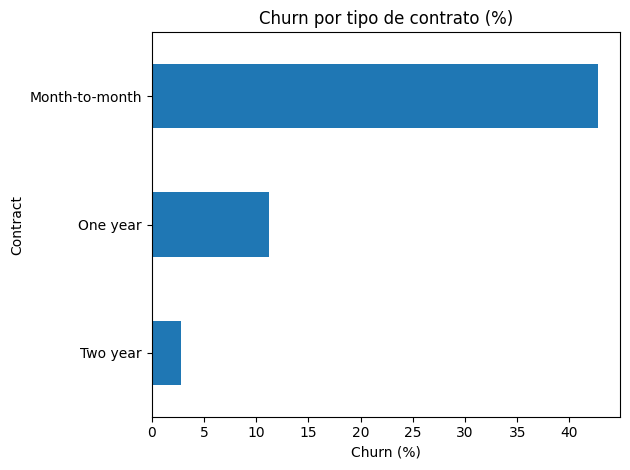

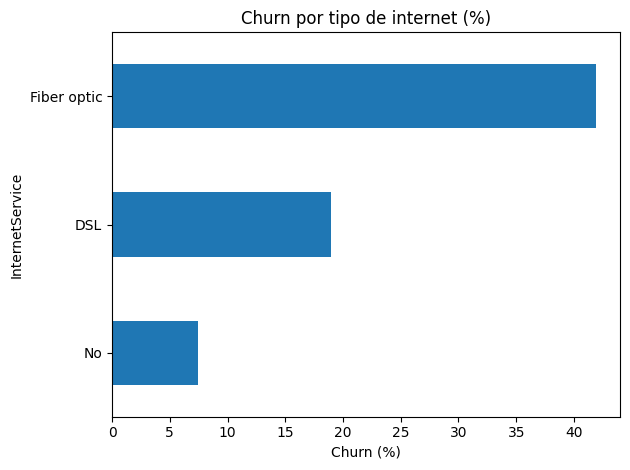

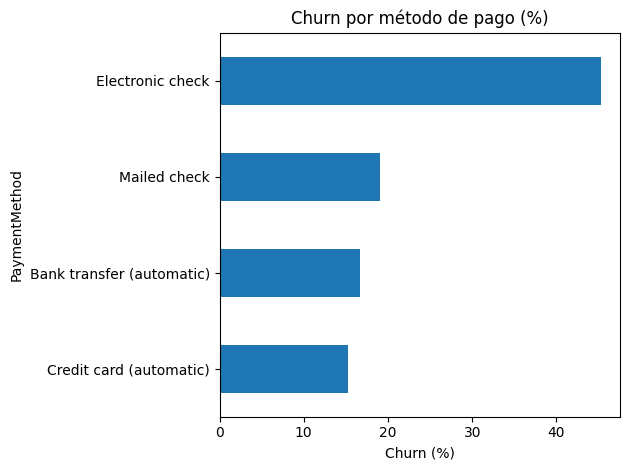

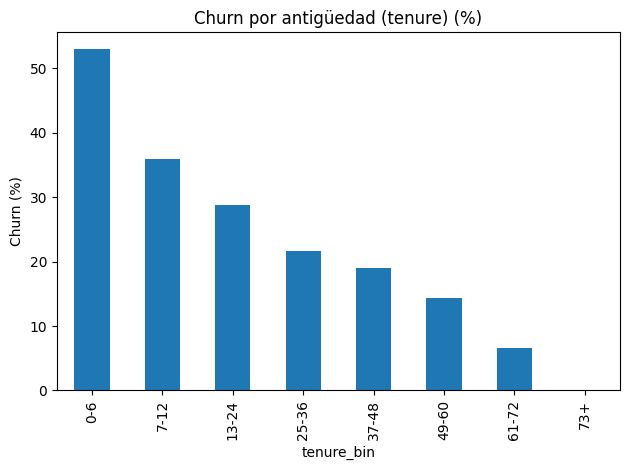

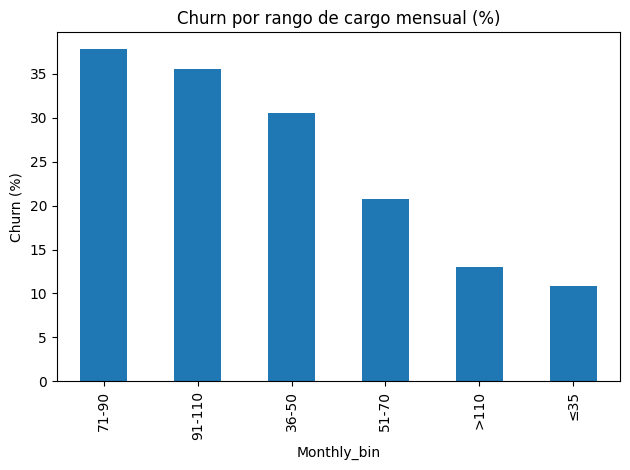

In [20]:
import matplotlib.pyplot as plt

def safe_bar(series, title, kind="barh"):
    # Convierte a numérico, rellena NaN con 0 solo para graficar
    s = pd.to_numeric(series, errors="coerce")
    if s.isna().all():
        print(f"[ADVERTENCIA] {title}: no hay datos numéricos que graficar.")
        display(series)
        return
    plt.figure()
    s.fillna(0).plot(kind=kind, title=title, legend=False)
    if kind == "barh":
        plt.xlabel("Churn (%)")
    else:
        plt.ylabel("Churn (%)")
    plt.tight_layout()
    plt.show()

# ===== Visualizaciones =====
safe_bar(kpi_contract.sort_values(ascending=True), "Churn por tipo de contrato (%)", kind="barh")
safe_bar(kpi_internet.sort_values(ascending=True), "Churn por tipo de internet (%)", kind="barh")
safe_bar(kpi_payment.sort_values(ascending=True), "Churn por método de pago (%)", kind="barh")
safe_bar(kpi_tenure,  "Churn por antigüedad (tenure) (%)", kind="bar")        # ya viene reindexado
safe_bar(kpi_monthly, "Churn por rango de cargo mensual (%)", kind="bar")     # ya viene reindexado


**Tablas de apoyo**

In [13]:
# ===== Conteos y cruce de variables para contexto =====
def crosstab_rate(rows, cols, data=None):
    data = df_labeled if data is None else data
    ct = pd.crosstab(data[rows], data[cols], normalize="index") * 100
    return ct.round(2)

# Proporción de Yes/No por contrato e internet
ct_contract = crosstab_rate("Contract", "Churn")
ct_internet = crosstab_rate("InternetService", "Churn")
ct_payment  = crosstab_rate("PaymentMethod", "Churn")
ct_tenure   = crosstab_rate("tenure_bin", "Churn")
ct_monthly  = crosstab_rate("Monthly_bin", "Churn")

display(ct_contract)
display(ct_internet)
display(ct_payment)
display(ct_tenure)
display(ct_monthly)


Churn,No,Yes
Contract,,
Month-to-month,57.29,42.71
One year,88.73,11.27
Two year,97.17,2.83


Churn,No,Yes
InternetService,,
DSL,81.04,18.96
Fiber optic,58.11,41.89
No,92.60,7.40


Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),83.29,16.71
Credit card (automatic),84.76,15.24
Electronic check,54.71,45.29
Mailed check,80.89,19.11


Churn,No,Yes
tenure_bin,,
0-6,47.06,52.94
7-12,64.11,35.89
13-24,71.29,28.71
25-36,78.37,21.63
37-48,80.97,19.03
49-60,85.58,14.42
61-72,93.39,6.61


Churn,No,Yes
Monthly_bin,,
≤35,89.11,10.89
36-50,69.50,30.50
51-70,79.24,20.76
71-90,62.20,37.80
91-110,64.44,35.56
>110,86.98,13.02


#📄Informe final

## Conclusiones ejecutivas

**1) El tipo de contrato es el principal diferenciador de churn.**  
Los **contratos mes a mes** presentan las tasas más altas de salida frente a planes **One year** / **Two year**, lo cual sugiere que la **falta de compromiso** y la **flexibilidad de cancelación** facilitan la evasión.

**2) El servicio de internet y el nivel de cargo mensual importan.**  
Clientes con **Fiber optic** y/o **cargos mensuales altos** muestran mayor churn, consistente con sensibilidad al precio y expectativas más altas de servicio.

**3) Método de pago con fricción, mayor churn.**  
Segmentos que usan **Electronic check** tienden a abandonar más que quienes usan **debit/credit automáticos** (hipótesis: **experiencia de pago** y falta de beneficios por débito automático).

**4) Tenure bajo = alto riesgo.**  
La **fase temprana** del ciclo de vida (0–12 meses) concentra mayor churn; la permanencia reduce la probabilidad de evasión conforme aumenta el tenure.

**5) Senioridad y otros factores.**  
Se observan diferencias moderadas por **SeniorCitizen** y **gender**; sin embargo, son **secundarias** frente a contrato, internet y precio.

---

## Recomendaciones de negocio (priorizadas)

1. **Migración a contratos de 1–2 años** con incentivos (descuentos por fidelidad, bundles de valor).  
2. **Ofertas de retención basadas en precio** para **altos cargos** y **Fiber optic** (p.ej., descuentos temporales, ajustes de velocidad adaptativos, upgrade de soporte).  
3. **Incentivar débito automático** (crédito/banco) con bonificaciones iniciales y eliminación de comisiones percibidas.  
4. **Programa “primeros 90 días”**: onboarding proactivo, comunicaciones de valor y check-ins para clientes nuevos (tenure bajo).  
5. **Propuesta de valor de seguridad/soporte**: reforzar **OnlineSecurity/TechSupport** como beneficios diferenciales en segmentos de alto churn.

> Estas acciones se alinean con el mandato del challenge: realizar ETL/EDA, elaborar conclusiones y comunicar **por qué** está ocurriendo la evasión y **cómo** mitigarlo. :contentReference[oaicite:8]{index=8} :contentReference[oaicite:9]{index=9}
